In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import datetime
import glob
import pandas as pd
from sklearn.linear_model import LogisticRegression
%matplotlib inline

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

/home/brad/DailyLog/20200127/


In [4]:
# cond: -1 = different, 1 = same class

def extract_submatrix(mat, h, pos):
    x, y = pos
    return mat[x*h:(x+1)*h, y*h:(y+1)*h].flatten()


def extract_same(submatrix, n_blocks):
    
    # first take care of the diagonal blocks
    for ind in range(n_blocks):
        submat = div_matrix[(20*i):20*(i+1), (20*i):20*(i+1)]
        dat = np.triu(submat, k=0)
        same_data.append(dat)
    return same_data

def same_diff_index_test(i, j, ntrial):
    
    c1 = (i // ntrial == j // ntrial) or (i // ntrial == (j // ntrial + 4))
    if c1:
        return "same"
    else: 
        return "different"

def build_lmm_dataset(div_matrix):
    
    n, _ = div_matrix.shape
    diff_mask = np.zeros((n, n))
    js_dat = []
    cond_dat = []
    for i in range(n):
        for j in range(i, n):
            js = div_matrix[i, j]
            cond = same_diff_index_test(i, j, 20)
            js_dat.append(js)
            cond_dat.append(cond)
            
    df_out = pd.DataFrame(data={'JS': js_dat,'cond': cond_dat})
    return df_out
        


def build_LRpredict_dataset(div_matrix):
    n, _ = div_matrix.shape
    print(n)
    LR_classes = np.concatenate([int(n/2)*['L'], int(n/2)*['R']])
    featmat = np.zeros((n, n-1))
    for trial in range(n):
        trialdat = div_matrix[trial, :]
        trialdat = np.concatenate([trialdat[0:trial], trialdat[trial+1:]])
        featmat[trial, :] = trialdat
    return (LR_classes, featmat)
    
    
def grouped_boxplot_with_scatter(data, order, ngroups=1, group_spacing=2, fig_path=None, colors=None, alphas=None, labels=None, positions=None, scatter_style=None, marker_size = 1, figsize=(5,4)):
    ''' From Zeke 
        Plot grouped boxplots
        data is in the form of a list of arrays, Ngroups*nboxes/group
    
    '''
    #colors = np.array(['pink', 'lightblue', 'lightgreen', 'pink', 'lightblue', 'lightgreen'])
    #alphas = np.array([0.25, 0.25, 0.25, 0.75, 0.75, 0.75])
    #labels = np.array(['CON/BOS', 'CON/Mot-wise', 'CON/Pc-wise', 'BOS/BOS', 'BOS/Mot-wise', 'BOS/Pc-wise'])
   
    nboxes = len(data)
    if alphas is None:
        alphas = np.array(nboxes*[1.0])
        
    dat_plot = [data[i] for i in order]
    
    # compute positions
    nboxes_per_group = int(int(len(data)) / int(ngroups))
    positions = np.arange(nboxes_per_group) +1
    for group in range(1, ngroups):
        positions = np.concatenate([positions, np.arange(max(positions)+group_spacing, max(positions)+group_spacing+nboxes_per_group)])
        
    
    box_plot_fig = plt.figure(figsize=figsize)
    ax = box_plot_fig.add_subplot(111)
    
    medianprops = dict(color='black')
    if positions is not None:
        box_plot = ax.boxplot(dat_plot, 0, '', positions=positions, patch_artist=False, whis='range', widths=1,
                              medianprops=medianprops)
        xlim1 = max(positions)+1
    else:
        box_plot = ax.boxplot(dat_plot, 0, '', patch_artist=False, whis='range', widths=1, medianprops=medianprops)
        xlim1 = max(order)+1

        
    # Do scatter
    scatter_plots = []
    
    for i in order:
        xs = np.array(len(data[i])*[positions[i]])+0.1*np.random.randn(len(data[i]))
        if scatter_style is None:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1) 
        else:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1, marker=scatter_style[i])
        scatter_plots.append(scatter_plot)
        
    # Compute group label positions
    labelpos =[]
    for group in range(ngroups):
        pos = positions[group*(nboxes_per_group):group*(nboxes_per_group)+nboxes_per_group]
        labelpos.append(np.mean(pos))
    
    plt.xticks(labelpos, labels, rotation=0)
    plt.grid(False)
    plt.ylim(0.0, 1)
    plt.xlim(0.0, xlim1)
    ax.tick_params(axis='both', labelsize=18)
    if colors is not None:
        for patch, color, alpha in zip(scatter_plots, colors[order], alphas[order]):
                patch.set_facecolor(color)
                #patch.set_alpha(0.0)
    
    #label_diff(1, 2, '**', dat_plot[0], dat_plot[1], ax)
    #plt.savefig(fig_path)
    return (box_plot_fig, positions)

def label_diff(i,j,text,X,Y, ax):
    x = (X[i]+X[j])/2.0
    y = 1.01*max(max(Y[i]), max(Y[j]))
    dx = abs(X[i]-X[j])
    print(x, y, dx)
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':50,'shrinkB':50,'linewidth':1}
    #props = {'connectionstyle':'bar','arrowstyle':'-','linewidth':1}
    ax.annotate(text, xy=(X[i], y), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)
    print(X[j], y)
    
from matplotlib.markers import TICKDOWN
def significance_bar(start,end,height,displaystring, stringheightfactor=1.0075, linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),stringheightfactor*height,displaystring,ha = 'center',va='center',size = fontsize)
    #bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad))


In [5]:
f_fam_orig_reps = glob.glob('/home/brad/DailyLog/20200120/JSpop_fast_B1083Split-1-1-20_LvsR-fam-orig-*.pkl')
f_fam_shuff_reps = glob.glob('/home/brad/DailyLog/20200122/JSpop_fast_B1083Split-1-1-20_LvsR-fam-shuff-*.pkl')
c_fam_orig_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_*.pkl')
c_fam_shuff_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_shuff_split_*.pkl')
from tqdm import tqdm
scsv_reps = []
scsv_shuff = []
for f_fam_orig, f_fam_shuff, c_fam_orig, c_fam_shuff in tqdm(zip(f_fam_orig_reps, f_fam_shuff_reps, c_fam_orig_reps, c_fam_shuff_reps)):
    

    with open(f_fam_orig, 'rb') as f:
        div = pickle.load(f)

    with open(f_fam_shuff, 'rb') as f:
        divs = pickle.load(f)
    with open(c_fam_orig, 'rb') as f:
        cdiv = pickle.load(f)

    with open(c_fam_shuff, 'rb') as f:
        cdivs = pickle.load(f)
        



    dataset = build_lmm_dataset(div)
    dataset_s = build_lmm_dataset(divs)
    dataset_c = build_lmm_dataset(cdiv)
    dataset_cs = build_lmm_dataset(cdivs)

    csss = [dataset, dataset_s, dataset_c, dataset_cs]
    #csss = [dataset]

    scsv = []
    for ds in tqdm(csss):

        N_tests = 240
        train_pct = 0.8
        test_pct = 1 - train_pct
        targ = ds['cond'].values
        feat = ds['JS'].values
        scores = []
        for test in range(N_tests):
            ntarg = int(train_pct*len(targ))
            perm = np.random.permutation(np.arange(len(targ)))
            targ_train = targ[perm[0:ntarg]]
            feat_train = feat[perm[0:ntarg]][:, np.newaxis]
            targ_test = targ[perm[ntarg:]]
            feat_test = feat[perm[ntarg:]][:, np.newaxis]
            lr = LogisticRegression()
            lr.fit(feat_train, targ_train)

            scores.append(lr.score(feat_test, targ_test))
        scsv.append(scores)
    scsv_reps.append(scsv)



0it [00:00, ?it/s]
100%|██████████| 4/4 [00:48<00:00, 12.06s/it]
1it [00:48, 48.34s/it]
100%|██████████| 4/4 [00:48<00:00, 12.15s/it]
2it [01:37, 48.51s/it]
100%|██████████| 4/4 [00:49<00:00, 12.34s/it]
3it [02:26, 48.83s/it]
100%|██████████| 4/4 [00:48<00:00, 12.21s/it]
4it [03:15, 48.86s/it]
100%|██████████| 4/4 [00:49<00:00, 12.33s/it]
5it [04:04, 48.97s/it]
100%|██████████| 4/4 [00:48<00:00, 12.13s/it]
6it [04:53, 48.91s/it]
100%|██████████| 4/4 [00:48<00:00, 12.09s/it]
7it [05:41, 48.84s/it]
100%|██████████| 4/4 [00:48<00:00, 12.12s/it]
8it [06:30, 48.81s/it]
100%|██████████| 4/4 [00:48<00:00, 12.13s/it]
9it [07:19, 48.79s/it]
100%|██████████| 4/4 [00:48<00:00, 12.13s/it]
10it [08:07, 48.77s/it]
100%|██████████| 4/4 [00:49<00:00, 12.29s/it]
11it [08:56, 48.81s/it]
100%|██████████| 4/4 [00:49<00:00, 12.35s/it]
12it [09:46, 48.87s/it]
100%|██████████| 4/4 [00:48<00:00, 12.07s/it]
13it [10:34, 48.83s/it]
100%|██████████| 4/4 [00:45<00:00, 11.34s/it]
14it [11:20, 48.59s/it]
100%|█████

100%|██████████| 4/4 [00:50<00:00, 12.61s/it]
32it [26:20, 49.38s/it]
100%|██████████| 4/4 [00:50<00:00, 12.74s/it]
33it [27:11, 49.43s/it]
100%|██████████| 4/4 [00:50<00:00, 12.72s/it]
34it [28:02, 49.48s/it]
100%|██████████| 4/4 [00:50<00:00, 12.54s/it]
35it [28:52, 49.50s/it]
100%|██████████| 4/4 [00:50<00:00, 12.58s/it]
36it [29:42, 49.53s/it]
100%|██████████| 4/4 [00:49<00:00, 12.49s/it]
37it [30:32, 49.54s/it]
100%|██████████| 4/4 [00:49<00:00, 12.43s/it]
38it [31:22, 49.55s/it]
100%|██████████| 4/4 [00:50<00:00, 12.53s/it]
39it [32:12, 49.56s/it]
100%|██████████| 4/4 [00:50<00:00, 12.58s/it]
40it [33:03, 49.59s/it]


In [ ]:
len(scsv_reps[0])

In [7]:
f = lambda x: list(map(np.mean, x))
test = np.transpose(list(map(f, scsv_reps)))


In [ ]:
test

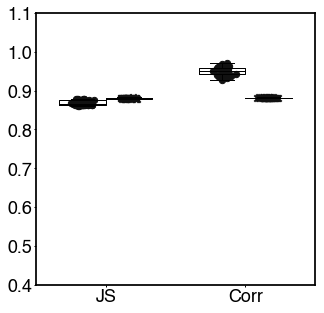

In [12]:

colors = ['#111111', '#111111', '#111111', '#111111']
marker_style = ['o', 'x', 'o', 'x']
colors = np.tile(['#111111', '#111111'], 2)
marker_style = np.tile(['o', 'x'], 2)
(fig, pos) = grouped_boxplot_with_scatter(test, order=range(4), ngroups=2, labels=['JS', 'Corr'], colors=colors, scatter_style=marker_style, figsize=(5,5), marker_size=40)


# significance_bar(pos[0],pos[1], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[0], pos[2], 1.03, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[2], pos[3], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')

# significance_bar(pos[4],pos[5], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[4], pos[6], 1.03, '***',  linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[6], pos[7], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
plt.ylim([0.40, 1.1])

plt.savefig(os.path.join(figsavepth, 'B1083_Split_JSDIVSTATS_predictstimulus.pdf'))

In [15]:
from scipy.stats import ttest_ind
ttests =[(0,1), (0, 2), (2,3)]
ttest_names = ['Pop1JS-Shuffle', 'Pop1JS-Pop1Corr', 'Pop1Corr-shuffle']
for t, n in zip(ttests, ttest_names):
    res = ttest_ind(test[t[0]], test[t[1]], equal_var=True)
    print('TEST: {}'.format(n))
    print(res)

TEST: Pop1JS-Shuffle
Ttest_indResult(statistic=-13.327209200869774, pvalue=8.453888687447337e-22)
TEST: Pop1JS-Pop1Corr
Ttest_indResult(statistic=-41.28024916982351, pvalue=9.326101265733858e-55)
TEST: Pop1Corr-shuffle
Ttest_indResult(statistic=38.64463510686004, pvalue=1.2638483598256272e-52)


In [ ]:
# Now for correlation
f_fam_orig_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_*.pkl')
f_fam_shuff_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_shuff_split_*.pkl')
print(f_fam_orig_reps)
print(f_fam_shuff_reps)
from tqdm import tqdm
scsv_reps = []
scsv_shuff = []
for f_fam_orig, f_fam_shuff in tqdm(zip(f_fam_orig_reps, f_fam_shuff_reps)):
    

    with open(f_fam_orig, 'rb') as f:
        div = pickle.load(f)

    with open(f_fam_shuff, 'rb') as f:
        divs = pickle.load(f)



    dataset = build_lmm_dataset(div)
    dataset_s = build_lmm_dataset(divs)

    csss = [dataset, dataset_s]
    #csss = [dataset]

    scsv = []
    for ds in tqdm(csss):

        N_tests = 240
        train_pct = 0.8
        test_pct = 1 - train_pct
        targ = ds['cond'].values
        feat = ds['JS'].values
        scores = []
        for test in range(N_tests):
            ntarg = int(train_pct*len(targ))
            perm = np.random.permutation(np.arange(len(targ)))
            targ_train = targ[perm[0:ntarg]]
            feat_train = feat[perm[0:ntarg]][:, np.newaxis]
            targ_test = targ[perm[ntarg:]]
            feat_test = feat[perm[ntarg:]][:, np.newaxis]
            lr = LogisticRegression()
            lr.fit(feat_train, targ_train)

            scores.append(lr.score(feat_test, targ_test))
        scsv.append(scores)
    scsv_reps.append(scsv)



In [ ]:
f = lambda x: [np.mean(x[0]), np.mean(x[1])]
test = np.transpose(list(map(f, scsv_reps)))

colors = ['#111111', '#111111']
marker_style = ['o', 'x']
(fig, pos) = grouped_boxplot_with_scatter(test, order=range(2), ngroups=1, labels=['Pop. 1'], colors=colors, scatter_style=marker_style, figsize=(5,8), marker_size=40)


significance_bar(pos[0],pos[1], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[0], pos[2], 1.03, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[2], pos[3], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')

significance_bar(pos[4],pos[5], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[4], pos[6], 1.03, '***',  linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[6], pos[7], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
plt.ylim([0.30, 1.1])

plt.savefig(os.path.join(figsavepth, 'B1083_Split_CorrDIVSTATS.pdf'.format(correlation_type)))

In [ ]:
from scipy.stats import ttest_ind
ttests =[(0,1)]
ttest_names = ['Pop1JS-Shuffle']
for t, n in zip(ttests, ttest_names):
    res = ttest_ind(test[t[0]], test[t[1]])
    print('TEST: {}'.format(n))
    print(res)